# UMAP and TSNE projections
We think dimension reduction strategies can provide some worthwile insights. For example, you may be project both asked questions and your corpus onto the same space to find out where your corpus is lacking information. Here we have drafted a notebook doing some experiments with UMAP and TSNE.

In [1]:
config = "Launchpad_five_models"
exclude_rejected = "False"

In [2]:
#Imports
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
import yaml
import random
import os, sys
root = os.environ["PROJECT_ROOT"]
sys.path.append(root)
from utils.utils_eval import load_results
from utils.utils import get_evaluator_models


c:\Users\VANEJ\Documents\git\RAG Evaluation with Minimal Labels\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
random.seed(0)
with open(os.path.join(root, "configs","experiments", f"{config}.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [5]:
dataset = config["dataset_name"]
buddies = config['buddies']
experiment_name = config['experiment_name']
data_types = ["Human", config['generated_dataset_name']]
output_path = os.path.join(root, "output", dataset, experiment_name)
output_path_figures = os.path.join(output_path, "figures")
root_path = os.environ.get("PROJECT_ROOT")

all_results, all_results_simple = load_results(
    output_path=output_path,
    data_types=data_types,
    buddies=buddies
)
print(f"Sample projections for {buddies[0]} predictions on the synthetic data")

Sample projections for Launchpad_4o_mini predictions on the synthetic data


In [6]:
questions = list(all_results[data_types[0]][buddies[0]]["user_input"].values())
answers = list(all_results[data_types[0]][buddies[0]]["response"].values())
scores = list(all_results[data_types[0]][buddies[0]]["semantic_similarity"].values())
#check where answers == "rejected"
non_answer_indices = [i for i, x in enumerate(answers) if x == "rejected"]
answer_indices = [i for i, x in enumerate(answers) if x != "rejected"]


if exclude_rejected:
    questions = [questions[i] for i in answer_indices]
    answers = [answers[i] for i in answer_indices]
    scores = [scores[i] for i in answer_indices]

N = len(questions)
print(N)


77


In [7]:
llm, embeddings = get_evaluator_models(
    llm_deployment="gpt-4o-mini",
    embedding_deployment="text-embedding-3-small"
)

In [8]:
question_embeddings = embeddings.embeddings.embed_documents(questions)

In [9]:
question_embeddings = np.array(question_embeddings)
question_embeddings.shape

(77, 1536)

In [10]:
answer_embeddings = embeddings.embeddings.embed_documents(answers)
answer_embeddings = np.array(answer_embeddings)

In [11]:
answer_embeddings = answer_embeddings[:190, :] #TODO update
question_embeddings = question_embeddings[:190, :]
combined_embeddings = np.concatenate([question_embeddings, answer_embeddings], axis=0)

In [12]:
answer_embeddings.shape

(77, 1536)

In [13]:
umap_embedding_questions = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=2, random_state=42).fit_transform(question_embeddings)
umap_embedding_answers = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=2, random_state=42).fit_transform(answer_embeddings)
umap_embedding_combined = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(combined_embeddings)


c:\Users\VANEJ\Documents\git\RAG Evaluation with Minimal Labels\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\VANEJ\Documents\git\RAG Evaluation with Minimal Labels\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\VANEJ\Documents\git\RAG Evaluation with Minimal Labels\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\VANEJ\Documents\git\RAG Evaluation with Minimal Labels\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\VANEJ\Documents\git\RAG Evaluation with Minimal Labels\.venv\Lib\site-package

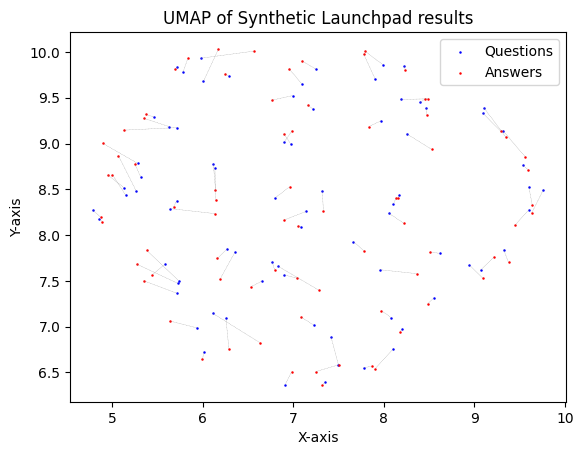

In [14]:
A = umap_embedding_combined[:N,:] #TODO make adaptive to n questions
B = umap_embedding_combined[N:,:]
# Create a scatter plot
plt.scatter(A[:, 0], A[:, 1], color='blue', label='Questions', s=0.6)
plt.scatter(B[:, 0], B[:, 1], color='red', label='Answers', s=0.6)

# Connect matching points with lines
for i in range(len(A)):
    plt.plot([A[i, 0], B[i, 0]], [A[i, 1], B[i, 1]], color='gray', linestyle='--', linewidth=0.2)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('UMAP of Synthetic Launchpad results')

# Show the plot
plt.show()

Text(0.5, 1.0, 'UMAP of Synthetic Launchpad Questions')

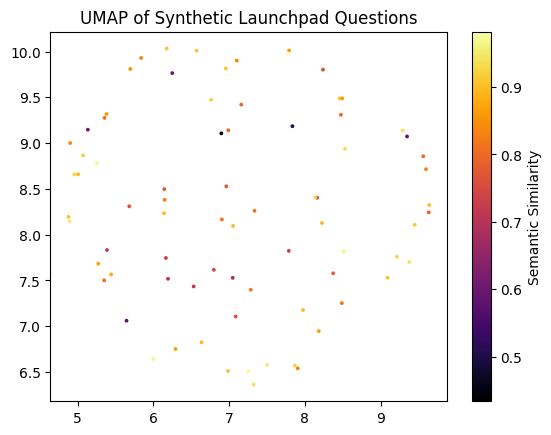

In [15]:
plt.scatter(B[:, 0], B[:, 1], c=scores, s=3, cmap='inferno')
colorbar =plt.colorbar()
colorbar.set_label('Semantic Similarity')
plt.title("UMAP of Synthetic Launchpad Questions")


## TSNE

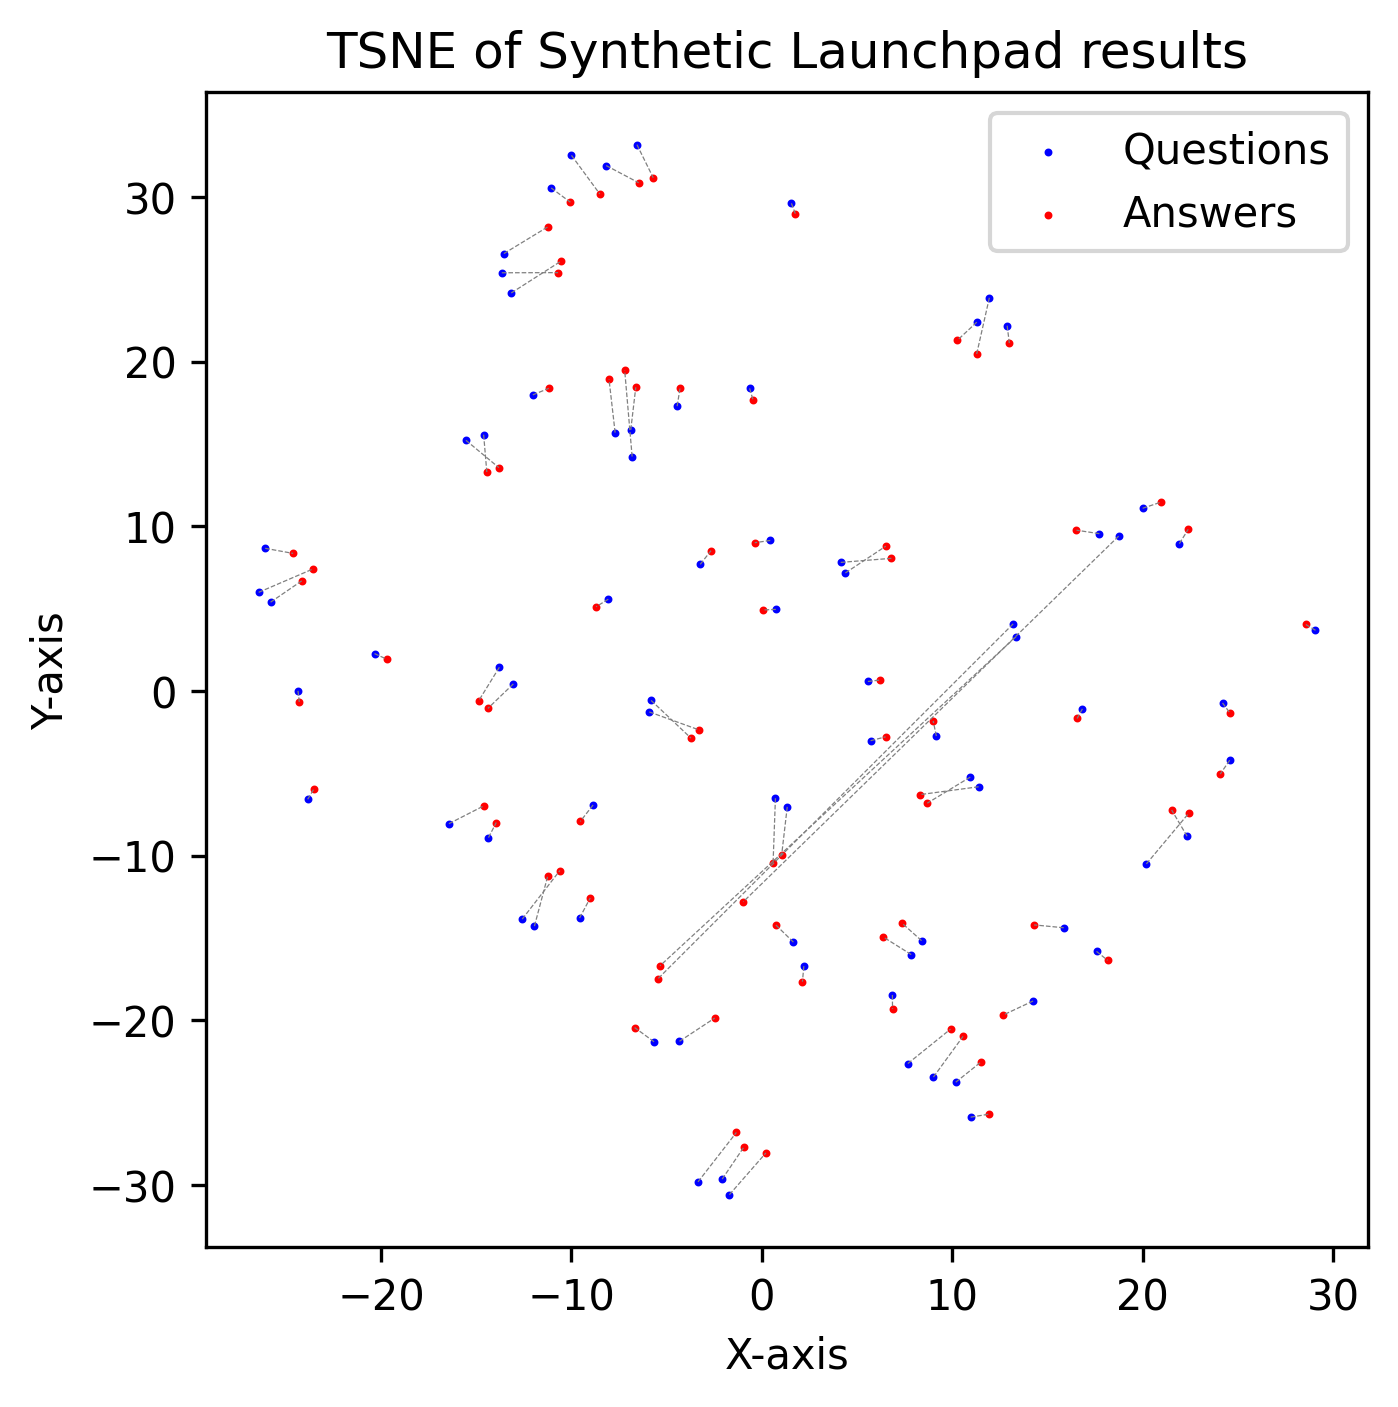

In [16]:
fig = plt.figure(figsize=(5, 5), dpi=300)
tsne_embedded = TSNE(n_components=2, perplexity=10, early_exaggeration=20, n_iter_without_progress=300).fit_transform(combined_embeddings)
A = tsne_embedded[:N,:]
B = tsne_embedded[N:,:]

# Create a scatter plot
plt.scatter(A[:, 0], A[:, 1], color='blue', label='Questions', s=0.8)
plt.scatter(B[:, 0], B[:, 1], color='red', label='Answers', s=0.8)

# Connect matching points with lines
for i in range(len(A)):
    plt.plot([A[i, 0], B[i, 0]], [A[i, 1], B[i, 1]], color='gray', linestyle='--', linewidth=0.3)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('TSNE of Synthetic Launchpad results')

# Show the plot
plt.show()